In [1]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
from ultralytics import YOLO
#import numpy as np
import matplotlib.pyplot as plt


In [4]:
model = YOLO("best (4).pt")

In [10]:
# Path to your test image (change this to your own image path)
image_path = "car6.jpg"

# Run detection
results = model(image_path, conf=0.98)  # confidence threshold 50%

# results[0] contains detections for the first (and only) image
results[0].show()   # OpenCV popup (if supported)


image 1/1 c:\Users\angelika\OneDrive\Documents\GitHub\dspCPE4A2526\dspPython\car6.jpg: 640x480 1 plate-number, 785.7ms
Speed: 7.2ms preprocess, 785.7ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 480)


In [6]:
pip install  pytesseract

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


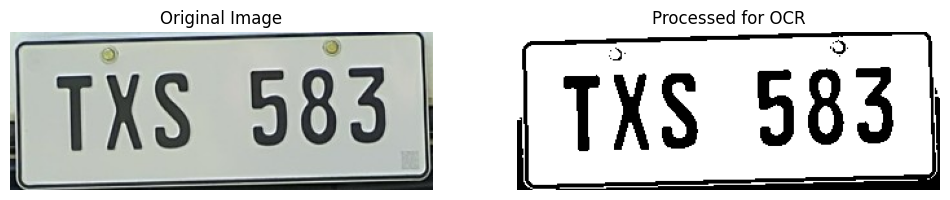

Extracted Text:
 TXS 583


In [11]:
import cv2
import pytesseract
from matplotlib import pyplot as plt
import re

# --- OPTIONAL: If tesseract is not in PATH, set the path manually ---
# For Windows, uncomment and adjust:
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def ocr_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Morphological noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # OCR with Tesseract
    raw_text = pytesseract.image_to_string(
        cleaned,
        config="--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 "
    )

    # --- CLEANUP: remove unwanted characters ---
    cleaned_text = re.sub(r"[^A-Z0-9]", "", raw_text).strip()

    # --- Insert space between letters and numbers ---
    match = re.search(r"([A-Z]{2,3})([0-9]{3,4})", cleaned_text)
    if match:
        cleaned_text = f"{match.group(1)} {match.group(2)}"

    # Show original and processed image inline (Jupyter)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(cleaned, cmap="gray")
    axs[1].set_title("Processed for OCR")
    axs[1].axis("off")

    plt.show()

    return cleaned_text

# Example usage
text_output = ocr_image("sample_text3.jpg")
print("Extracted Text:\n", text_output)



0: 1280x960 1 plate-number, 3889.3ms
Speed: 30.4ms preprocess, 3889.3ms inference, 9.9ms postprocess per image at shape (1, 3, 1280, 960)


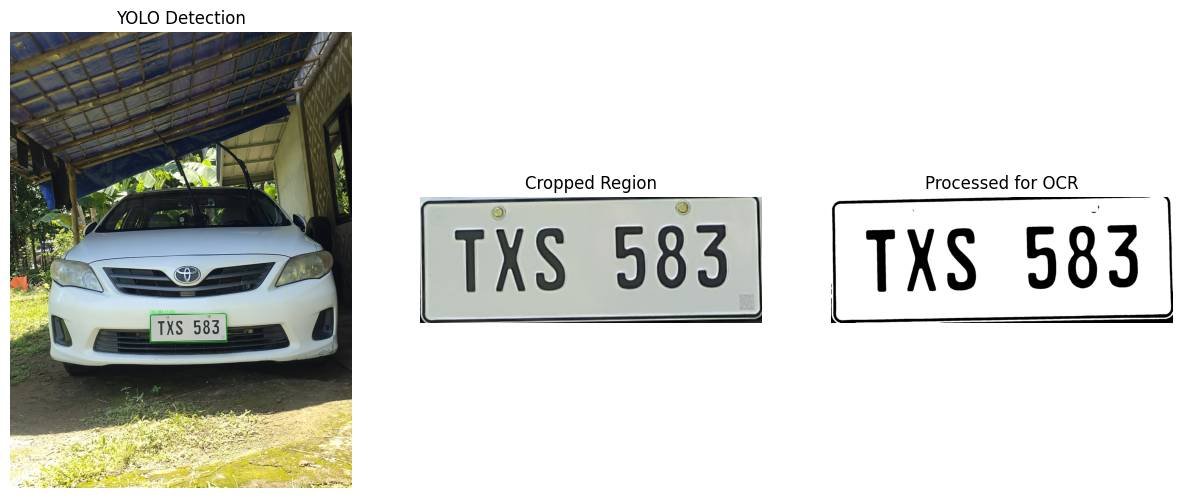

Extracted Text: TXS 583
Detection Confidence: 1.00


In [12]:
import cv2
import pytesseract
from ultralytics import YOLO
import matplotlib.pyplot as plt
import re
import numpy as np

# --- Load your trained plate detection model ---
model = YOLO("best (3).pt")

def detect_and_ocr(image_path):
    # --- Load image ---
    img = cv2.imread(image_path)
    
    # --- YOLO detection: only 1 plate detected ---
    results = model(img, conf=0.3, imgsz=1280, max_det=1)  # max_det=1 ensures only one box

    if len(results[0].boxes) == 0:
        print("No plates detected")
        return "", 0

    # --- Pick the single best box ---
    best_box = results[0].boxes[0]
    x1, y1, x2, y2 = map(int, best_box.xyxy[0].cpu().numpy())
    best_conf = float(best_box.conf[0])
    plate_crop = img[y1:y2, x1:x2]

    # --- Preprocess for OCR ---
    gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    gray = cv2.bilateralFilter(gray, 9, 75, 75)
    gray = cv2.convertScaleAbs(gray, alpha=1.5, beta=30)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    gray = cv2.filter2D(gray, -1, kernel)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # --- OCR ---
    ocr_images = [gray, thresh]
    raw_text = ""
    for ocr_img in ocr_images:
        raw_text = pytesseract.image_to_string(
            ocr_img,
            config="--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        ).strip().upper()
        if raw_text:
            break

    # --- Clean text ---
    cleaned = re.sub(r"[^A-Z0-9\s]", "", raw_text)
    match = re.search(r"([A-Z]{3})\s*([0-9]{3,4})", cleaned)
    plate_text = f"{match.group(1)} {match.group(2)}" if match else cleaned

    # --- Visualization ---
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    img_box = img.copy()
    cv2.rectangle(img_box, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_box, f"{plate_text} ({best_conf:.2f})", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    axs[0].imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
    axs[0].set_title("YOLO Detection")
    axs[0].axis("off")

    axs[1].imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Cropped Region")
    axs[1].axis("off")

    axs[2].imshow(thresh, cmap="gray")
    axs[2].set_title("Processed for OCR")
    axs[2].axis("off")

    plt.show()

    return plate_text, best_conf

# --- Run the function ---
result_text, confidence = detect_and_ocr("Car6.jpg")
print(f"Extracted Text: {result_text}")
print(f"Detection Confidence: {confidence:.2f}")
